<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto utilizando la layer Embedding de Keras. Se utilizará esos embeddings junto con layers LSTM para predeccir la próxima posible palabra.

In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional

### Datos
Utilizaremos como dataset el libro La Metamorfósis de Franz Kafka, en español.

In [2]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('La_Metamorfosis.txt', sep='/n', header=None)
df.head()

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,0
0,Cuando Gregorio Samsa se despertó una mañana d...
1,"Sus muchas patas, ridículamente pequeñas en co..."
2,"Por encima de la mesa, sobre la que se encontr..."
3,La mirada de Gregorio se dirigió después hacia...
4,Aunque se lanzase con mucha fuerza hacia el la...


In [3]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 279


### 1 - Ejemplo de Preprocesamiento
- Hay que transformar las oraciones en tokens.
- Dichas oraciones hay que ajustarlas al tamaño fijo de nuestra sentencia de entrada al modelo.
- Hay que separar las palabras objetivos (target) que el modelo debe predecir en cada sentencia armada.

In [4]:
from keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from keras.preprocessing.text import text_to_word_sequence # equivalente a word_teokenize de nltk
from keras.preprocessing.sequence import pad_sequences # se utilizará para padding

# largo de la secuencia, incluye seq input + word output
train_len = 4

In [5]:
# Ejemplo de como transformar una oración a tokens usando keras
text = df.loc[0,0]
text

'Cuando Gregorio Samsa se despertó una mañana después de un sueño intranquilo, se encontró sobre su cama convertido en un monstruoso insecto. Estaba tumbado sobre su espalda dura, y en forma de caparazón y, al levantar un poco la cabeza, veía un vientre abombado, parduzco, dividido por partes duras en forma de arco, sobre cuya protuberancia apenas podía mantenerse el cobertor, a punto ya de resbalar al suelo.'

In [6]:
tokens = text_to_word_sequence(text) # entran oraciones -> salen vectores de N posiciones (tokens)
tokens

['cuando',
 'gregorio',
 'samsa',
 'se',
 'despertó',
 'una',
 'mañana',
 'después',
 'de',
 'un',
 'sueño',
 'intranquilo',
 'se',
 'encontró',
 'sobre',
 'su',
 'cama',
 'convertido',
 'en',
 'un',
 'monstruoso',
 'insecto',
 'estaba',
 'tumbado',
 'sobre',
 'su',
 'espalda',
 'dura',
 'y',
 'en',
 'forma',
 'de',
 'caparazón',
 'y',
 'al',
 'levantar',
 'un',
 'poco',
 'la',
 'cabeza',
 'veía',
 'un',
 'vientre',
 'abombado',
 'parduzco',
 'dividido',
 'por',
 'partes',
 'duras',
 'en',
 'forma',
 'de',
 'arco',
 'sobre',
 'cuya',
 'protuberancia',
 'apenas',
 'podía',
 'mantenerse',
 'el',
 'cobertor',
 'a',
 'punto',
 'ya',
 'de',
 'resbalar',
 'al',
 'suelo']

1.1 - Transformar las oraciones en secuencias (tokens) de palabras

In [7]:
# Recorrer todas las filas y transformar las oraciones
# en secuencias de palabras
sentence_tokens = []
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

In [8]:
# Demos un vistazo
sentence_tokens[:2]

[['cuando',
  'gregorio',
  'samsa',
  'se',
  'despertó',
  'una',
  'mañana',
  'después',
  'de',
  'un',
  'sueño',
  'intranquilo',
  'se',
  'encontró',
  'sobre',
  'su',
  'cama',
  'convertido',
  'en',
  'un',
  'monstruoso',
  'insecto',
  'estaba',
  'tumbado',
  'sobre',
  'su',
  'espalda',
  'dura',
  'y',
  'en',
  'forma',
  'de',
  'caparazón',
  'y',
  'al',
  'levantar',
  'un',
  'poco',
  'la',
  'cabeza',
  'veía',
  'un',
  'vientre',
  'abombado',
  'parduzco',
  'dividido',
  'por',
  'partes',
  'duras',
  'en',
  'forma',
  'de',
  'arco',
  'sobre',
  'cuya',
  'protuberancia',
  'apenas',
  'podía',
  'mantenerse',
  'el',
  'cobertor',
  'a',
  'punto',
  'ya',
  'de',
  'resbalar',
  'al',
  'suelo'],
 ['sus',
  'muchas',
  'patas',
  'ridículamente',
  'pequeñas',
  'en',
  'comparación',
  'con',
  'el',
  'resto',
  'de',
  'su',
  'tamaño',
  'le',
  'vibraban',
  'desamparadas',
  'ante',
  'los',
  'ojos',
  '«¿qué',
  'me',
  'ha',
  'ocurrido',
 

In [9]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []

for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [10]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences

[['cuando', 'gregorio', 'samsa', 'se'],
 ['gregorio', 'samsa', 'se', 'despertó'],
 ['samsa', 'se', 'despertó', 'una'],
 ['se', 'despertó', 'una', 'mañana'],
 ['despertó', 'una', 'mañana', 'después'],
 ['una', 'mañana', 'después', 'de'],
 ['mañana', 'después', 'de', 'un'],
 ['después', 'de', 'un', 'sueño'],
 ['de', 'un', 'sueño', 'intranquilo'],
 ['un', 'sueño', 'intranquilo', 'se'],
 ['sueño', 'intranquilo', 'se', 'encontró'],
 ['intranquilo', 'se', 'encontró', 'sobre'],
 ['se', 'encontró', 'sobre', 'su'],
 ['encontró', 'sobre', 'su', 'cama'],
 ['sobre', 'su', 'cama', 'convertido'],
 ['su', 'cama', 'convertido', 'en'],
 ['cama', 'convertido', 'en', 'un'],
 ['convertido', 'en', 'un', 'monstruoso'],
 ['en', 'un', 'monstruoso', 'insecto'],
 ['un', 'monstruoso', 'insecto', 'estaba'],
 ['monstruoso', 'insecto', 'estaba', 'tumbado'],
 ['insecto', 'estaba', 'tumbado', 'sobre'],
 ['estaba', 'tumbado', 'sobre', 'su'],
 ['tumbado', 'sobre', 'su', 'espalda'],
 ['sobre', 'su', 'espalda', 'dura'],


1.2 - Crear los vectores de palabras (word2vec)

Ahora necesitamos pasarlos a números para que lo entienda la red y separar input de output.
- El Input seran integers (word2vec)
- Mientras que el output será one hot encodeado (labels) del tamaño del vocabulario

In [11]:
tok = Tokenizer() 

# El tokeinzer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

In [12]:
# Ahora sequences tiene los números "ID", largo 4
sequences

[[52, 50, 49, 5],
 [50, 49, 5, 10],
 [49, 5, 10, 11],
 [5, 10, 11, 12],
 [10, 11, 12, 13],
 [11, 12, 13, 2],
 [12, 13, 2, 1],
 [13, 2, 1, 14],
 [2, 1, 14, 15],
 [1, 14, 15, 5],
 [14, 15, 5, 16],
 [15, 5, 16, 3],
 [5, 16, 3, 6],
 [16, 3, 6, 17],
 [3, 6, 17, 18],
 [6, 17, 18, 4],
 [17, 18, 4, 1],
 [18, 4, 1, 19],
 [4, 1, 19, 20],
 [1, 19, 20, 21],
 [19, 20, 21, 22],
 [20, 21, 22, 3],
 [21, 22, 3, 6],
 [22, 3, 6, 23],
 [3, 6, 23, 24],
 [6, 23, 24, 7],
 [23, 24, 7, 4],
 [24, 7, 4, 8],
 [7, 4, 8, 2],
 [4, 8, 2, 25],
 [8, 2, 25, 7],
 [2, 25, 7, 9],
 [25, 7, 9, 26],
 [7, 9, 26, 1],
 [9, 26, 1, 27],
 [26, 1, 27, 28],
 [1, 27, 28, 29],
 [27, 28, 29, 30],
 [28, 29, 30, 1],
 [29, 30, 1, 31],
 [30, 1, 31, 32],
 [1, 31, 32, 33],
 [31, 32, 33, 34],
 [32, 33, 34, 35],
 [33, 34, 35, 36],
 [34, 35, 36, 37],
 [35, 36, 37, 4],
 [36, 37, 4, 8],
 [37, 4, 8, 2],
 [4, 8, 2, 38],
 [8, 2, 38, 3],
 [2, 38, 3, 39],
 [38, 3, 39, 40],
 [3, 39, 40, 41],
 [39, 40, 41, 42],
 [40, 41, 42, 43],
 [41, 42, 43, 44],
 [42,

In [13]:
# Cantidad de casos (doc) de entrada
print(tok.document_count)

64


In [14]:
# Cantidad de veces que aparece cada palabra
print(len(tok.word_counts))

52


In [15]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'un': 1, 'de': 2, 'sobre': 3, 'en': 4, 'se': 5, 'su': 6, 'y': 7, 'forma': 8, 'al': 9, 'despertó': 10, 'una': 11, 'mañana': 12, 'después': 13, 'sueño': 14, 'intranquilo': 15, 'encontró': 16, 'cama': 17, 'convertido': 18, 'monstruoso': 19, 'insecto': 20, 'estaba': 21, 'tumbado': 22, 'espalda': 23, 'dura': 24, 'caparazón': 25, 'levantar': 26, 'poco': 27, 'la': 28, 'cabeza': 29, 'veía': 30, 'vientre': 31, 'abombado': 32, 'parduzco': 33, 'dividido': 34, 'por': 35, 'partes': 36, 'duras': 37, 'arco': 38, 'cuya': 39, 'protuberancia': 40, 'apenas': 41, 'podía': 42, 'mantenerse': 43, 'el': 44, 'cobertor': 45, 'a': 46, 'punto': 47, 'ya': 48, 'samsa': 49, 'gregorio': 50, 'resbalar': 51, 'cuando': 52}


In [16]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'cuando': 1, 'se': 8, 'gregorio': 2, 'samsa': 3, 'despertó': 4, 'una': 4, 'mañana': 4, 'después': 4, 'de': 15, 'un': 16, 'sueño': 4, 'intranquilo': 4, 'encontró': 4, 'sobre': 12, 'su': 8, 'cama': 4, 'convertido': 4, 'en': 12, 'monstruoso': 4, 'insecto': 4, 'estaba': 4, 'tumbado': 4, 'espalda': 4, 'dura': 4, 'y': 8, 'forma': 8, 'caparazón': 4, 'al': 5, 'levantar': 4, 'poco': 4, 'la': 4, 'cabeza': 4, 'veía': 4, 'vientre': 4, 'abombado': 4, 'parduzco': 4, 'dividido': 4, 'por': 4, 'partes': 4, 'duras': 4, 'arco': 4, 'cuya': 4, 'protuberancia': 4, 'apenas': 4, 'podía': 4, 'mantenerse': 4, 'el': 4, 'cobertor': 4, 'a': 4, 'punto': 4, 'ya': 4, 'resbalar': 2})


### 2 - Preprocesamiento completo
Debemos realizar los mismos pasos que en el ejemplo anterior, pero antes de eso debemos transformar ese dataset de filas de oraciones en un texto completo continuo para poder extraer el vocabulario.

In [17]:
# Vistazo a las primeras filas
df.loc[:15,0]

0     Cuando Gregorio Samsa se despertó una mañana d...
1     Sus muchas patas, ridículamente pequeñas en co...
2     Por encima de la mesa, sobre la que se encontr...
3     La mirada de Gregorio se dirigió después hacia...
4     Aunque se lanzase con mucha fuerza hacia el la...
5     «Esto de levantarse pronto», pensó, «le hace a...
6     Eso podría intentar yo con mi jefe, en ese mom...
7     Bueno, la esperanza todavía no está perdida de...
8     Eran las seis y media y las manecillas seguían...
9     Así pues, intentó en primer lugar sacar de la ...
10    Pero como, jadeando después de semejante esfue...
11    Pero al mismo tiempo no olvidaba recordar de v...
12    Si se dejaba caer de ella de esta forma, la ca...
13    Lo más difícil, a su modo de ver, era tener cu...
14    Pero había que intentarlo. Cuando Gregorio ya ...
15    Bueno, aparte de que las puertas estaban cerra...
Name: 0, dtype: object

In [18]:
# Concatenamos todos los rows en un solo valor
corpus = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]
corpus

"Cuando Gregorio Samsa se despertó una mañana después de un sueño intranquilo, se encontró sobre su cama convertido en un monstruoso insecto. Estaba tumbado sobre su espalda dura, y en forma de caparazón y, al levantar un poco la cabeza, veía un vientre abombado, parduzco, dividido por partes duras en forma de arco, sobre cuya protuberancia apenas podía mantenerse el cobertor, a punto ya de resbalar al suelo. Sus muchas patas, ridículamente pequeñas en comparación con el resto de su tamaño, le vibraban desamparadas ante los ojos. «¿Qué me ha ocurrido?», pensó. No era un sueño. Su habitación, una auténtica habitación humana, si bien algo pequeña, permanecía tranquila entre las cuatro paredes harto conocidas. Por encima de la mesa, sobre la que se encontraba extendido un muestrario de paños desempaquetados – Samsa era viajante de comercio –, estaba colgado aquel cuadro, que hacía poco había recortado de una revista y había colocado en un bonito marco dorado. Representaba a una dama atavi

In [19]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens
tokens[:20]

['cuando',
 'gregorio',
 'samsa',
 'se',
 'despertó',
 'una',
 'mañana',
 'después',
 'de',
 'un',
 'sueño',
 'intranquilo',
 'se',
 'encontró',
 'sobre',
 'su',
 'cama',
 'convertido',
 'en',
 'un']

In [20]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 20675


In [21]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [22]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:20]

[['cuando', 'gregorio', 'samsa', 'se'],
 ['gregorio', 'samsa', 'se', 'despertó'],
 ['samsa', 'se', 'despertó', 'una'],
 ['se', 'despertó', 'una', 'mañana'],
 ['despertó', 'una', 'mañana', 'después'],
 ['una', 'mañana', 'después', 'de'],
 ['mañana', 'después', 'de', 'un'],
 ['después', 'de', 'un', 'sueño'],
 ['de', 'un', 'sueño', 'intranquilo'],
 ['un', 'sueño', 'intranquilo', 'se'],
 ['sueño', 'intranquilo', 'se', 'encontró'],
 ['intranquilo', 'se', 'encontró', 'sobre'],
 ['se', 'encontró', 'sobre', 'su'],
 ['encontró', 'sobre', 'su', 'cama'],
 ['sobre', 'su', 'cama', 'convertido'],
 ['su', 'cama', 'convertido', 'en'],
 ['cama', 'convertido', 'en', 'un'],
 ['convertido', 'en', 'un', 'monstruoso'],
 ['en', 'un', 'monstruoso', 'insecto'],
 ['un', 'monstruoso', 'insecto', 'estaba']]

In [23]:
# Proceso de tokenizacion
tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:20]

[[44, 12, 68, 8],
 [12, 68, 8, 530],
 [68, 8, 530, 18],
 [8, 530, 18, 110],
 [530, 18, 110, 58],
 [18, 110, 58, 2],
 [110, 58, 2, 14],
 [58, 2, 14, 296],
 [2, 14, 296, 1451],
 [14, 296, 1451, 8],
 [296, 1451, 8, 531],
 [1451, 8, 531, 41],
 [8, 531, 41, 11],
 [531, 41, 11, 69],
 [41, 11, 69, 668],
 [11, 69, 668, 6],
 [69, 668, 6, 14],
 [668, 6, 14, 1452],
 [6, 14, 1452, 1453],
 [14, 1452, 1453, 37]]

In [24]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 20671


### 3 - Input y target

In [25]:
# Con numpy es muy fácil realizar el slicing de vectores
ex = np.array([[1,2,3,4],[5,6,7,8]])
ex

array([[1, 2, 3, 4],
       [5, 6, 7, 8]])

In [26]:
# Con numpy es muy fácil realizar el slicing de vectores
print("Dimension:", ex.shape)
print("Todos los elementos:", ex)
print("Todos los elementos menos el último:", ex[:, :-1])

Dimension: (2, 4)
Todos los elementos: [[1 2 3 4]
 [5 6 7 8]]
Todos los elementos menos el último: [[1 2 3]
 [5 6 7]]


In [27]:
input = ex[:,:-1] # todos los rows, menos la ultima col
target = ex[:, -1] # última col de cada row

print("Input:", input)
print("Target:", target)

Input: [[1 2 3]
 [5 6 7]]
Target: [4 8]


In [28]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(20671, 3)
(20671,)


In [29]:
# Palabras del vocabulario
tok.index_word

{1: 'la',
 2: 'de',
 3: 'que',
 4: 'y',
 5: 'el',
 6: 'en',
 7: 'a',
 8: 'se',
 9: 'con',
 10: 'no',
 11: 'su',
 12: 'gregorio',
 13: 'por',
 14: 'un',
 15: '–',
 16: 'había',
 17: 'los',
 18: 'una',
 19: 'las',
 20: 'pero',
 21: 'al',
 22: 'lo',
 23: 'le',
 24: 'del',
 25: 'ya',
 26: 'más',
 27: 'como',
 28: 'para',
 29: 'hermana',
 30: 'habitación',
 31: 'padre',
 32: 'si',
 33: 'todo',
 34: 'madre',
 35: 'sus',
 36: 'hacia',
 37: 'estaba',
 38: 'puerta',
 39: 'sin',
 40: 'era',
 41: 'sobre',
 42: 'tenía',
 43: 'porque',
 44: 'cuando',
 45: 'él',
 46: 'podía',
 47: 'vez',
 48: 'ahora',
 49: 'sólo',
 50: 'tiempo',
 51: 'apoderado',
 52: 'ella',
 53: 'es',
 54: 'señor',
 55: 'dijo',
 56: 'otra',
 57: 'hubiese',
 58: 'después',
 59: 'poco',
 60: 'cabeza',
 61: 'mismo',
 62: 'momento',
 63: 'habían',
 64: 'muy',
 65: 'desde',
 66: 'esta',
 67: 'ni',
 68: 'samsa',
 69: 'cama',
 70: 'incluso',
 71: 'forma',
 72: 'entonces',
 73: 'familia',
 74: 'así',
 75: 'allí',
 76: 'este',
 77: 'bien',

In [30]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

3549

In [31]:
# Transformar los datos a oneHotEncoding
# y_data = to_categorical(y_data_int, num_classes=vocab_size)

In [32]:
# En el caso anterior explota porque y_data_int comienza en "1" en vez de "0"
# valor minimo:
min(y_data_int)

1

In [33]:
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size) 
y_data.shape

(20671, 3549)

### 4 - Entrenar el modelo

In [34]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1] 
input_seq_len

3

In [35]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

3549

In [46]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=30, input_length=input_seq_len))

model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Dropout(0.5))
model.add(LSTM(512)) # La última capa LSTM no lleva return_sequences

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 3, 30)             106500    
                                                                 
 bidirectional_6 (Bidirectio  (None, 3, 512)           587776    
 nal)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 3, 512)            0         
                                                                 
 bidirectional_7 (Bidirectio  (None, 3, 512)           1574912   
 nal)                                                            
                                                                 
 dropout_11 (Dropout)        (None, 3, 512)            0         
                                                                 
 lstm_8 (LSTM)               (None, 512)              

In [47]:
hist = model.fit(x_data, y_data, epochs=100, validation_split=0.2)

Epoch 1/100
517/517 [==============================] - 15s 16ms/step - loss: 6.4412 - accuracy: 0.0471 - val_loss: 6.3032 - val_accuracy: 0.0392
Epoch 2/100
517/517 [==============================] - 7s 13ms/step - loss: 5.9643 - accuracy: 0.0682 - val_loss: 6.3065 - val_accuracy: 0.0711
Epoch 3/100
517/517 [==============================] - 7s 13ms/step - loss: 5.6970 - accuracy: 0.0807 - val_loss: 6.3828 - val_accuracy: 0.0689
Epoch 4/100
517/517 [==============================] - 7s 13ms/step - loss: 5.4900 - accuracy: 0.0893 - val_loss: 6.4788 - val_accuracy: 0.0784
Epoch 5/100
517/517 [==============================] - 7s 13ms/step - loss: 5.3027 - accuracy: 0.1003 - val_loss: 6.7253 - val_accuracy: 0.0817
Epoch 6/100
517/517 [==============================] - 7s 13ms/step - loss: 5.1218 - accuracy: 0.1127 - val_loss: 6.7956 - val_accuracy: 0.0832
Epoch 7/100
517/517 [==============================] - 7s 13ms/step - loss: 4.9516 - accuracy: 0.1240 - val_loss: 7.0243 - val_accuracy

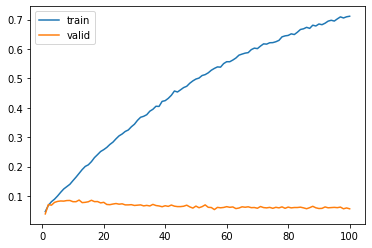

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### 5 - Predicción de próxima palabra

In [49]:
# Keras pad_sequences
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
# Si la secuencia de entrada supera al input_seq_len (3) se trunca
# Si la secuencia es más corta se agregna ceros al comienzo

In [50]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/
import sys
!{sys.executable} -m pip install gradio --quiet

In [51]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')
    
    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

iface.launch(debug=True)

/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: `layout` parameter is deprecated, and it has no effect
  warnings.warn(value)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://27927.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces: https://huggingface.co/spaces


Keyboard interruption in main thread... closing server.


(<gradio.routes.App at 0x7f70c8fd7d50>,
 'http://127.0.0.1:7860/',
 'https://27927.gradio.app')

### 6 - Generación de secuencias nuevas

In [52]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		
		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [65]:
input_texts=['abre la puerta', 'la esperanza todavía', 'retrocedía lentamente como', 'perder el trabajo', 'no parecía tener', 'por la mañana', 'de nuevo se']

for input_text in input_texts:
  print(generate_seq(model, tok, input_text, max_length=3, n_words=2))

abre la puerta y eran
la esperanza todavía con su
retrocedía lentamente como padre lo
perder el trabajo que con
no parecía tener cerradura »
por la mañana trataba la
de nuevo se sentaron sus


### 7 - Conclusiones
El modelo entrenado tuvo un muy mail desempeño en el entrenamiento además de overfitting. Cuestiones que podrían mejorarse:
- Agregar más capas o neuronaes
- Incrementar la cantidad de épocas
- Agregar BRNN

Es importante destacar que en este ejemplo estamos entrenando nuestro propios Embeddings, y para ello se requiere mucha data. En los ejemplos que realizaremos de aquí en más utilizaremos más datos, embeddings pre-enternados o modelos pre-entrenados.

### Notas:

Se experimentó con diferentes arquitecturas de redes neuronales, agregando más neuronas y quitándolas. Modificando la cantidad de capas LSTM y también fully connected, también se realizaron pruebas con y sin capas bidireccionales (LSTM) y alterando el Dropout. En todos los casos se observó overfitting, no obstante el modelo final presenta resultados satisfactorios teniendo en cuenta la baja cantidad de datos con los que se entrenó el modelo.